In [14]:
import pickle
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from captum.attr import (
    DeepLift,
    FeatureAblation,
    GradientShap,
    IntegratedGradients,
    NoiseTunnel,
    Occlusion,
    GradientShap,
)
from spender.data.desi import DESI
from outlier_attribution.model import OutlierModel
from tqdm.auto import tqdm

plt.style.use("js")

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
trainloader = DESI.get_data_loader(
    "/scratch/gpfs/yanliang/desi-dynamic",
    which="train",
    batch_size=16,
    shuffle=True,
    shuffle_instance=True,
)

In [4]:
get_baselines = lambda: next(iter(trainloader))[0].to(device).reshape(16, len(DESI._wave_obs))

In [5]:
weight_dir = "/scratch/gpfs/js5013/programs/outlier-attribution/weights"
model = OutlierModel.from_weights(
    f"{weight_dir}/spender.desi-edr.galaxyae-b9bc8d12.pt",
    f"{weight_dir}/galaxy-flow-state_dict.pt",
).to(device)

In [6]:
with open("../data/DESI_EDR_top200_outliers.pkl", "rb") as f:
    data = pickle.load(f)

spectra = (
    torch.tensor(np.stack([data[i]["spectrum"] for i in range(1, 201)]))
    .to(device)
    .requires_grad_()
)

In [7]:
selkeys = ["target_id", "z", "ra", "dec", "-logP"]
metadata = dict(
    zip(
        selkeys,
        (
            torch.tensor(np.stack([data[i][k] for i in range(1, 201)])).to(device)
            for k in selkeys
        ),
    )
)

In [8]:
ig = IntegratedGradients(model)
fa = FeatureAblation(model)
oc = Occlusion(model)

In [40]:
def expected_attributes(spectrum, baselines):
    spectrum = spectrum.unsqueeze(0)
    attributions = []
    for b in baselines:
        attributions.append(ig.attribute(spectrum, b.unsqueeze(0)))
    attributions = torch.stack(attributions)
    return torch.sum(attributions, axis=0).squeeze(0)

In [10]:
def instantaneous_gradient(spectrum):
    mdl = lambda x: model(x.unsqueeze(0)).squeeze()
    return torch.func.grad(mdl)(spectrum)

In [52]:
def feature_ablation(spectrum, baseline):
    with torch.no_grad():
        assert spectrum.shape == baseline.shape
        assert spectrum.ndim == 1
        mask = torch.ones_like(spectrum, dtype=bool) # all like spectrum
        ref_output = model(spectrum.unsqueeze(0)).squeeze() # reference output to compare to
        grad = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store grads
        new = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store new array
        for i in tqdm(range(len(spectrum)), leave=False):
            mask[i] = False # replace spectral element with baseline
            new[:] = torch.where(mask, spectrum, baseline) 
            new_output = model(new.unsqueeze(0)).squeeze() # calculate new output
            grad[i] = ref_output - new_output # save difference
            mask[i] = True # put spectra element back
        return grad

def expected_ablation(spectrum, baselines):
    attributions = []
    for b in tqdm(baselines):
        attributions.append(feature_ablation(spectrum, b))
    attributions = torch.stack(attributions)
    return torch.mean(attributions, dim=0)

In [53]:
ix = 111

In [ ]:
inst_attr = instantaneous_gradient(spectra[ix])
efa_attr = expected_ablation(spectra[ix], get_baselines())
eg_attr = expected_attributes(spectra[ix], get_baselines())

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/7781 [00:00<?, ?it/s]

  0%|          | 0/7781 [00:00<?, ?it/s]

  0%|          | 0/7781 [00:00<?, ?it/s]

  0%|          | 0/7781 [00:00<?, ?it/s]

  0%|          | 0/7781 [00:00<?, ?it/s]

  0%|          | 0/7781 [00:00<?, ?it/s]

  0%|          | 0/7781 [00:00<?, ?it/s]

  0%|          | 0/7781 [00:00<?, ?it/s]

  0%|          | 0/7781 [00:00<?, ?it/s]

  0%|          | 0/7781 [00:00<?, ?it/s]

In [51]:
attribution_labels = [
    "Instantaneous Gradient",
    "Expected Gradients",
    "Expected Ablation",
]

In [ ]:
attributions = torch.stack([inst_attr, efa_attr, eg_attr])

Text(0.5, 0.98, 'Outlier 112\nID=39633413543562464, z=0.2631\nRA=191.74307, Dec=62.37470\nlogP=-12.756')

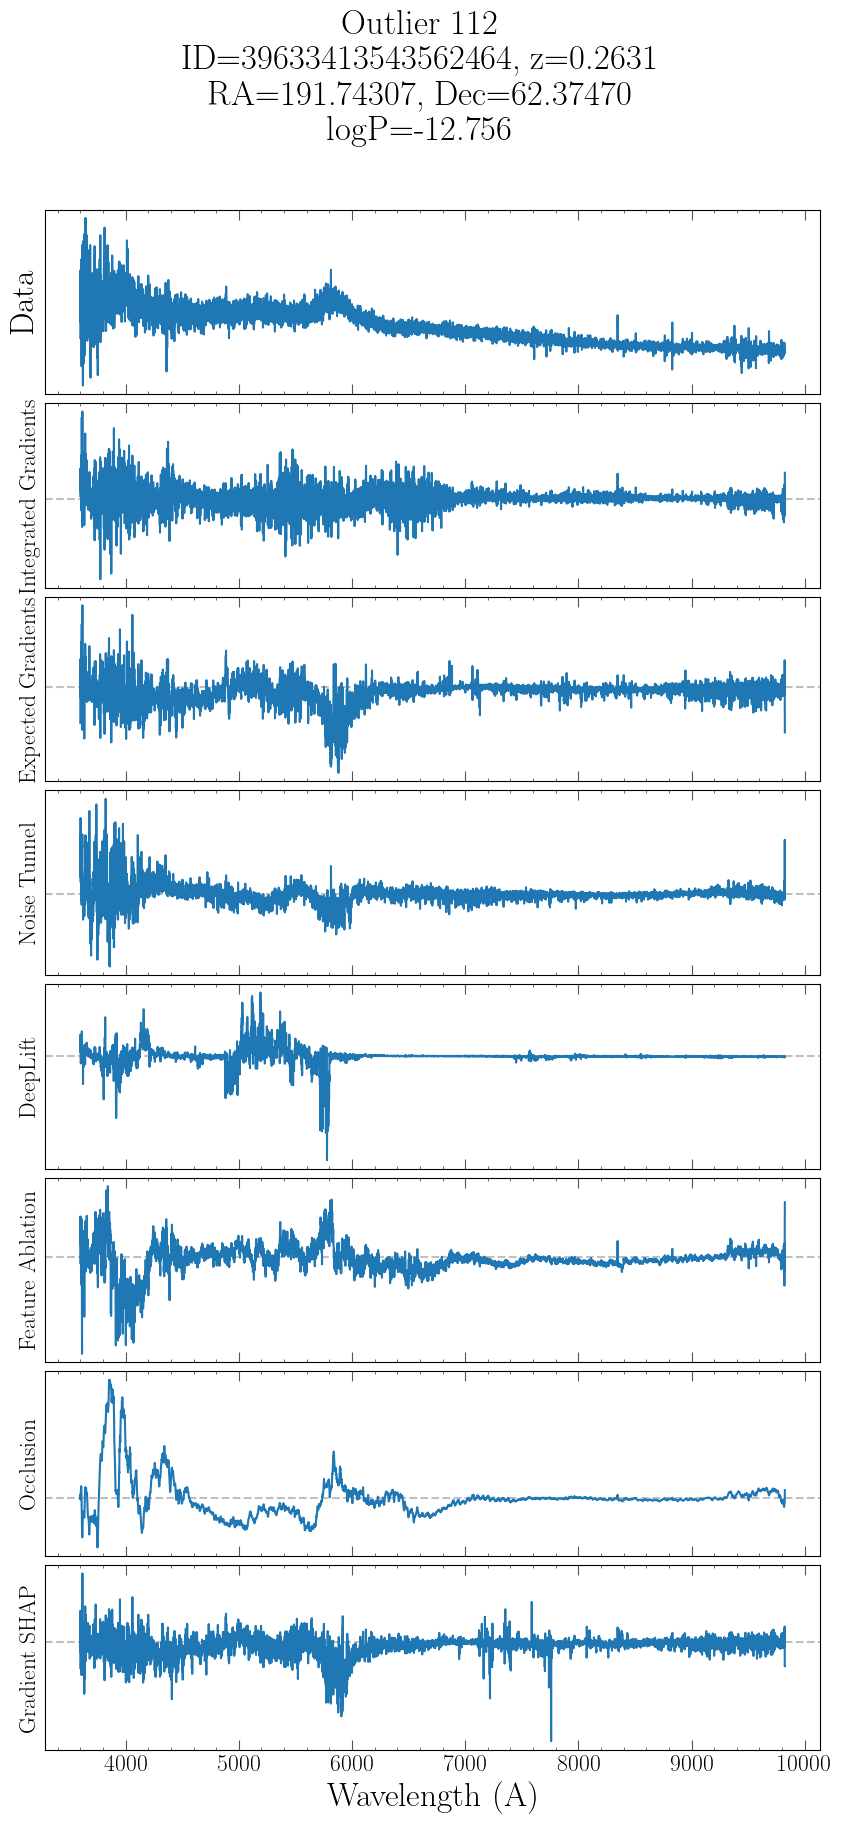

In [14]:
nattr = len(attributions)

fig, ax = plt.subplots(
    nattr + 1, 1, figsize=(10, 5 + nattr * 3), sharex=True, gridspec_kw=dict(hspace=0.05)
)

ax[0].plot(
    DESI._wave_obs,
    spectra[ix - 1].detach().cpu().numpy(),
)
[
    ax[j + 1].plot(
        DESI._wave_obs,
        attributions[j, 0].detach().cpu().numpy(),
        label=attribution_labels[j],
    )
    for j in range(nattr)
]
[ax[j + 1].axhline(0, c="gray", alpha=0.5, ls="--", zorder=-5) for j in range(nattr)]
ax[0].set_ylabel("Data")
[ax[j + 1].set_ylabel(attribution_labels[j], fontsize=17) for j in range(nattr)]
for a in ax:
    a.set_yticks([])
plt.xlabel("Wavelength (A)")
plt.suptitle(
    f"Outlier {ix}\nID={metadata['target_id'][ix-1]}, z={metadata['z'][ix-1]:.4f}\nRA={metadata['ra'][ix-1]:.5f}, Dec={metadata['dec'][ix-1]:.5f}\nlogP={-metadata['-logP'][ix-1]:.3f}",
    fontsize=25,
)